In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load data
data = pd.read_csv("Data Historis PANS Harian 2020-2025.csv", sep=",", dtype=str)
data

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,18/06/2025,1.595,1.600,1.605,1.590,"189,60K","0,00%"
1,17/06/2025,1.595,1.580,1.600,1.580,"276,00K","0,95%"
2,16/06/2025,1.580,1.560,1.590,1.555,"155,60K","1,28%"
3,13/06/2025,1.560,1.565,1.570,1.550,"353,10K","0,00%"
4,12/06/2025,1.560,1.565,1.570,1.555,"339,10K","0,65%"
...,...,...,...,...,...,...,...
1295,24/01/2020,1.340,1.350,1.350,1.320,"14,30K","-3,25%"
1296,23/01/2020,1.385,1.340,1.385,1.340,"1,30K","4,92%"
1297,22/01/2020,1.320,1.360,1.390,1.320,"341,80K","-2,58%"
1298,21/01/2020,1.355,1.360,1.360,1.350,"55,30K","-0,37%"


In [3]:
print(data.dtypes)

Tanggal       object
Terakhir      object
Pembukaan     object
Tertinggi     object
Terendah      object
Vol.          object
Perubahan%    object
dtype: object


In [4]:
# Convert 'Tanggal' to datetime
data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%d/%m/%Y')

# Convert target columns to numeric, removing dots
target_columns = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in target_columns:
    data[col] = data[col].str.replace('.', '').astype(int)

# Sort data by date
data = data.sort_values('Tanggal')
data.set_index('Tanggal', inplace=True)

# Display last few rows
data.tail()

,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
Tanggal,,,,,,
2025-06-12,1560,1565,1570,1555,"339,10K","0,65%"
2025-06-13,1560,1565,1570,1550,"353,10K","0,00%"
2025-06-16,1580,1560,1590,1555,"155,60K","1,28%"
2025-06-17,1595,1580,1600,1580,"276,00K","0,95%"
2025-06-18,1595,1600,1605,1590,"189,60K","0,00%"


In [5]:
data.isnull().sum()

Terakhir      0
Pembukaan     0
Tertinggi     0
Terendah      0
Vol.          0
Perubahan%    0
dtype: int64

In [6]:
data.describe()

,Terakhir,Pembukaan,Tertinggi,Terendah
count,1300.000000,1300.000000,1300.000000,1300.000000
mean,1451.150000,1453.650000,1471.192308,1434.146154
std,326.155264,325.139996,323.997776,326.563395
min,640.000000,625.000000,680.000000,625.000000
25%,1265.000000,1270.000000,1285.000000,1250.000000
50%,1555.000000,1552.500000,1570.000000,1535.000000
75%,1670.000000,1670.000000,1685.000000,1655.000000
max,2090.000000,2130.000000,2190.000000,2050.000000


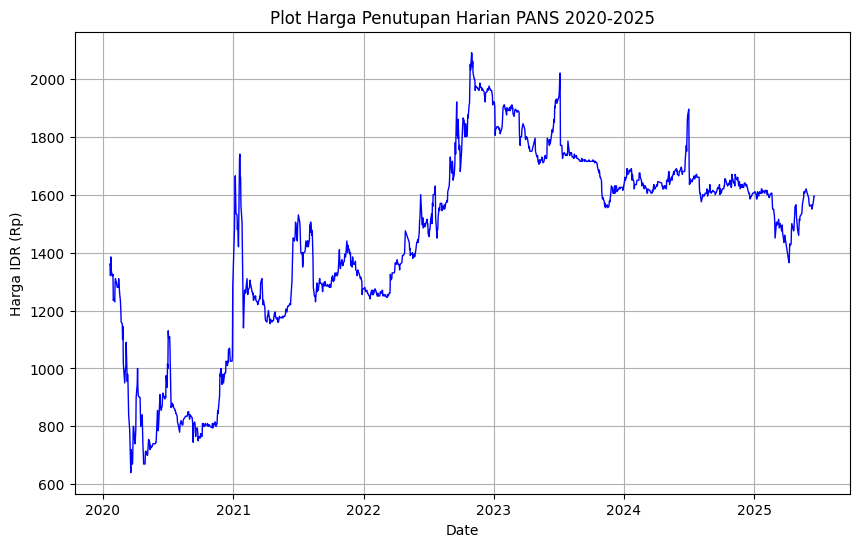

In [7]:
# Visualize initial time series
plt.figure(figsize=(10, 6))
plt.plot(data['Terakhir'], color='blue', linewidth=1)
plt.title('Plot Harga Penutupan Harian PANS 2020-2025')
plt.xlabel('Date')
plt.ylabel('Harga IDR (Rp)')
plt.grid(True)
plt.show()

# ARIMA

In [8]:
ts_data = pd.Series(data['Terakhir'])

#--- 1. Pembagian Data Training dan Testing ---
train_size = int(len(ts_data) * 0.9)
train_data, test_data = ts_data[0:train_size], ts_data[train_size:]

print(f"Ukuran Data Training: {len(train_data)}")
print(f"Ukuran Data Testing: {len(test_data)}")

# Stationarity test (ADF test)
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    print()

adf_test(train_data, 'Train Series')
train_diff1_series = train_data.diff().dropna()
adf_test(train_diff1_series, 'Differenced Series')


Ukuran Data Training: 1170
Ukuran Data Testing: 130
ADF Test: Train Series
ADF Statistic: -1.5473033335463133
p-value: 0.5099949342457045
Critical Values:
   1%: -3.436009632917059
   5%: -2.864039124493168
   10%: -2.5681005921710054

ADF Test: Differenced Series
ADF Statistic: -9.375217729468066
p-value: 7.19781297699071e-16
Critical Values:
   1%: -3.4360342309571053
   5%: -2.864049975956835
   10%: -2.568106371425197



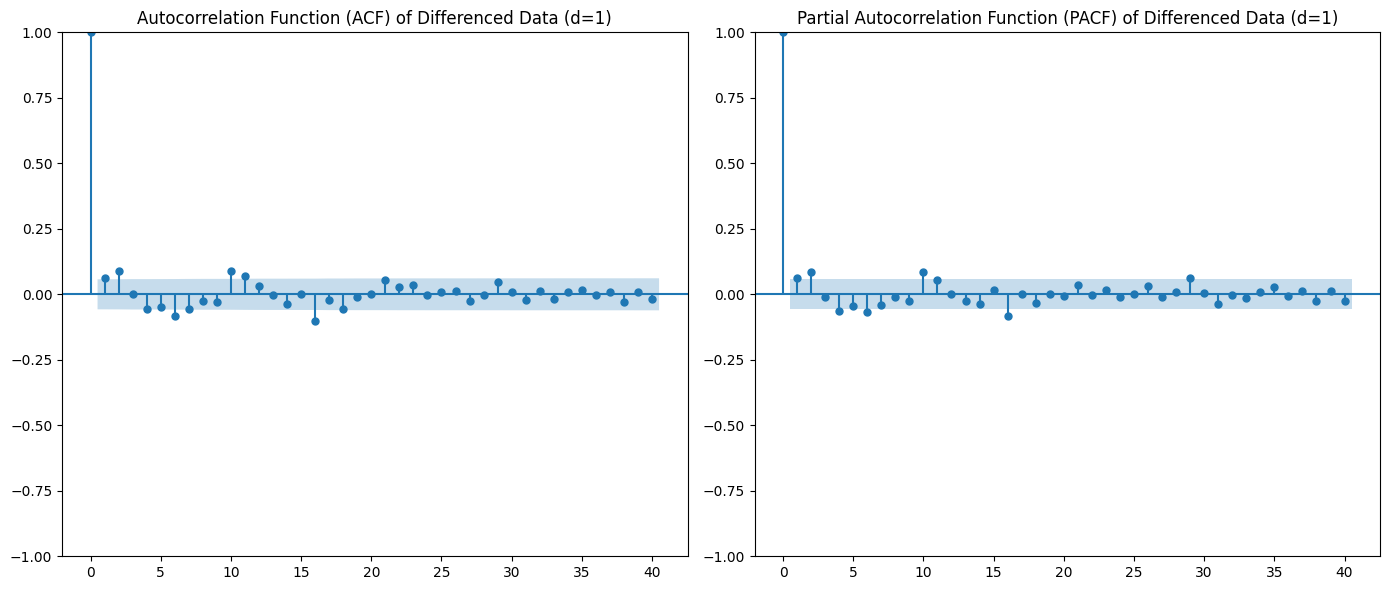

In [9]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(train_data.diff().dropna(), lags=40, ax=plt.gca(), title=f'Autocorrelation Function (ACF) of Differenced Data (d={1})')
plt.subplot(122)
plot_pacf(train_data.diff().dropna(), lags=40, ax=plt.gca(), title=f'Partial Autocorrelation Function (PACF) of Differenced Data (d={1})')
plt.tight_layout()
plt.show()

In [10]:
results = []
p_values = range(0, 6)
d = 1
q_values = range(0, 6)

for p in p_values:
    for q in q_values:
        try:
            model_arima = ARIMA(train_data, order=(p, d, q), trend = 't')
            fitted = model_arima.fit()
            results.append({
                'p': p,
                'd': d,
                'q': q,
                'AIC': fitted.aic,
                'BIC': fitted.bic
            })
        except:
            continue

# Simpan ke DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AIC')

# Tampilkan 10 kombinasi terbaik
print("Top 10 kombinasi ARIMA (p,d,q) berdasarkan AIC:")
print(results_df.head(10))

c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

Top 10 kombinasi ARIMA (p,d,q) berdasarkan AIC:
    p  d  q           AIC           BIC
20  3  1  2  11286.771288  11322.218615
15  2  1  3  11286.870229  11322.317556
22  3  1  4  11287.492606  11333.067742
26  4  1  2  11288.416571  11328.927803
21  3  1  3  11288.433422  11328.944653
16  2  1  4  11288.455181  11328.966412
28  4  1  4  11289.190126  11339.829166
17  2  1  5  11289.974688  11335.549824
23  3  1  5  11291.095638  11341.734678
29  4  1  5  11291.652378  11347.355321


c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
# ARIMA modeling
arima_model = ARIMA(train_data, order=(3,1,2))  # Auto ARIMA dari R
arima_fit = arima_model.fit()
print(arima_fit.summary())

c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Terakhir   No. Observations:                 1170
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5636.427
Date:                Sat, 21 Jun 2025   AIC                          11284.853
Time:                        13:33:40   BIC                          11315.237
Sample:                             0   HQIC                         11296.313
                               - 1170                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4820      0.064     23.154      0.000       1.357       1.607
ar.L2         -0.7818      0.080     -9.755      0.000      -0.939      -0.625
ar.L3         -0.0502      0.024     -2.135      0.0

In [12]:
# Prediksi pada data training (in-sample predictions)
# statsmodels ARIMA.predict() bisa mengembalikan nilai dari awal deret atau dari 'start'
# kita gunakan start=0 dan end=len(train_data)-1 untuk in-sample
train_predictions = arima_fit.predict(start=0, end=len(train_data)-1)

# Sesuaikan train_data dengan panjang train_predictions
if len(train_predictions) < len(train_data):
    train_data_aligned = train_data.iloc[len(train_data) - len(train_predictions):]
else:
    train_data_aligned = train_data.copy()

# Pastikan indeks train_predictions sama dengan train_data_aligned
train_predictions = pd.Series(train_predictions, index=train_data_aligned.index)

# Prediksi pada data testing (out-of-sample predictions)
# Menggunakan get_forecast untuk memprediksi masa depan
forecast_result = arima_fit.get_forecast(steps=len(test_data))
test_predictions = forecast_result.predicted_mean
test_predictions.index = test_data.index

print("\n--- Metrik Evaluasi Model ARIMA ---")

# Metrik untuk Data Training
mse_train = mean_squared_error(train_data_aligned, train_predictions)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(train_data_aligned, train_predictions)
mape_train = np.mean(np.abs((train_data_aligned - train_predictions) / train_data)) * 100

print(f"Metrik Training:")
print(f"  MSE  : {mse_train:.2f}")
print(f"  RMSE : {rmse_train:.2f}")
print(f"  MAE  : {mae_train:.2f}")
print(f"  MAPE : {mape_train:.2f}%")

# Metrik untuk Data Testing
mse_test = mean_squared_error(test_data, test_predictions)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_data, test_predictions)
mape_test = np.mean(np.abs((test_data - test_predictions) / test_data)) * 100

print(f"\nMetrik Testing:")
print(f"  MSE  : {mse_test:.2f}")
print(f"  RMSE : {rmse_test:.2f}")
print(f"  MAE  : {mae_test:.2f}")
print(f"  MAPE : {mape_test:.2f}%")


--- Metrik Evaluasi Model ARIMA ---
Metrik Training:
  MSE  : 2482.77
  RMSE : 49.83
  MAE  : 18.29
  MAPE : 1.41%

Metrik Testing:
  MSE  : 13411.65
  RMSE : 115.81
  MAE  : 96.81
  MAPE : 6.38%


c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava


--- Prediksi Harga ke Depan ---
2025-06-19    1595.368317
2025-06-20    1593.748573
2025-06-21    1591.043778
2025-06-22    1588.286902
2025-06-23    1586.401985
Freq: D, dtype: float64


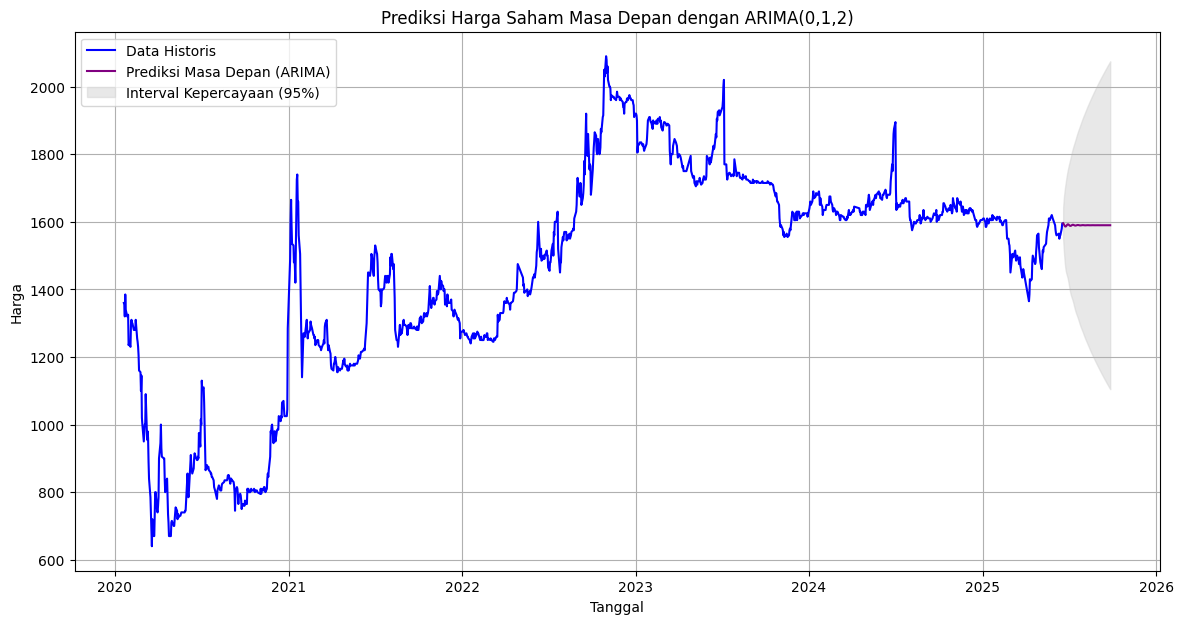

In [13]:
# Forecast with ARIMA
forecast_steps = 100
arima_model = ARIMA(data['Terakhir'], order=(3,1,2))  # Auto ARIMA dari R
arima_fit = arima_model.fit()
arima_forecast = arima_fit.get_forecast(steps=forecast_steps)
arima_forecast_mean = arima_forecast.predicted_mean
CI_df = arima_forecast.conf_int(alpha=0.1).astype(float)

#Buat indeks tanggal untuk hasil prediksi masa depan
last_date = ts_data.index[-1]
future_index = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=len(arima_forecast_mean), freq='D')

future_forecast_series = pd.Series(arima_forecast_mean.values, index=future_index)
CI_df.index = future_index # Sesuaikan indeks confidence interval

print("\n--- Prediksi Harga ke Depan ---")
print(future_forecast_series.head())

# Visualisasi Prediksi Masa Depan
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data, label='Data Historis', color='blue')
plt.plot(future_forecast_series.index, future_forecast_series, label='Prediksi Masa Depan (ARIMA)', color='purple')
plt.fill_between(CI_df.index,
                 CI_df.iloc[:, 0], # Kolom lower bound
                 CI_df.iloc[:, 1], # Kolom upper bound
                 color='lightgray', alpha=0.5, label='Interval Kepercayaan (95%)')
plt.title('Prediksi Harga Saham Masa Depan dengan ARIMA(0,1,2)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

# LSTM

In [26]:
# LSTM Preprocessing
# Normalize data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data[['Terakhir']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(normalized_data, seq_length)

# Split data
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set - X shape: {X_train.shape}, y shape: {y_train.shape}")
print(f"Testing set - X shape: {X_test.shape}, y shape: {y_test.shape}")

Training set - X shape: (1116, 60, 1), y shape: (1116, 1)
Testing set - X shape: (124, 60, 1), y shape: (124, 1)


In [63]:
# Membangun model LSTM
model_lstm = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(32),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model_lstm.summary()

# Train model
history = model_lstm.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

c:\Users\izzyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,465 (486.19 KB)

 Trainable params: 124,465 (486.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0965 - mae: 0.2211 - val_loss: 0.0029 - val_mae: 0.0494
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0075 - mae: 0.0664 - val_loss: 5.7056e-04 - val_mae: 0.0150
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0043 - mae: 0.0476 - val_loss: 0.0012 - val_mae: 0.0293
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0043 - mae: 0.0480 - val_loss: 8.8509e-04 - val_mae: 0.0236
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0039 - mae: 0.0452 - val_loss: 5.9175e-04 - val_mae: 0.0155
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0033 - mae: 0.0417 - val_loss: 5.5285e-04 - val_mae: 0.0148
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0032 - mae: 0.0402 - val_loss: 7.8530e-04 - val_mae: 0.0208
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0031 - mae: 0.0400 - val_loss: 8.0118e-04 - val_mae: 0.0221
Epoch 9/100
28/28 ━━━━━━━━━━━━

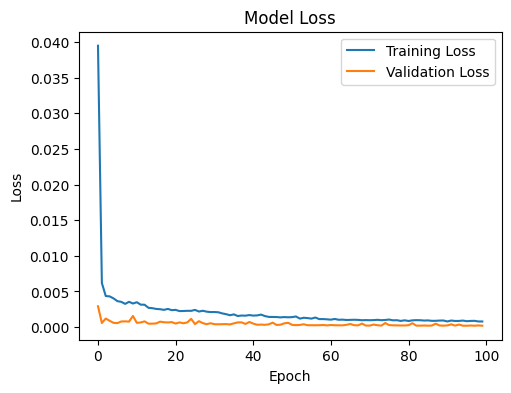

In [64]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

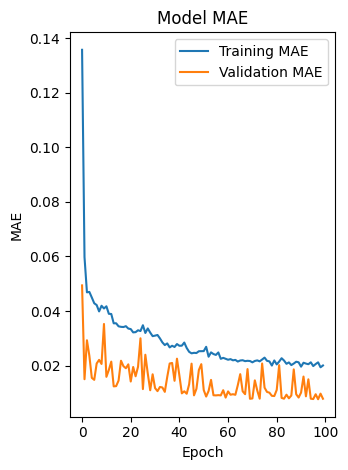

In [65]:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
model_lstm = load_model('lstm_model_2.h5', compile=False)

In [69]:
# Evaluate model
# Training predictions
pred_train = model_lstm.predict(X_train)
pred_train_denorm = scaler.inverse_transform(pred_train)
y_train_denorm = scaler.inverse_transform(y_train)

# Calculate metrics
mse_train = mean_squared_error(y_train_denorm, pred_train_denorm)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_denorm, pred_train_denorm)
mape_train = np.mean(np.abs((y_train_denorm - pred_train_denorm) / y_train_denorm)) * 100

print("Training Metrics:")
print(f"RMSE: {rmse_train:.3f}")
print(f"MAE: {mae_train:.3f}")
print(f"MAPE: {mape_train:.3f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Training Metrics:
RMSE: 30.878
MAE: 19.103
MAPE: 1.472%


In [70]:
# Test predictions
predictions = model_lstm.predict(X_test)
predictions_denorm = scaler.inverse_transform(predictions)
y_test_denorm = scaler.inverse_transform(y_test)

# Calculate metrics
mse_test = mean_squared_error(y_test_denorm, predictions_denorm)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_denorm, predictions_denorm)
mape_test = np.mean(np.abs((y_test_denorm - predictions_denorm) / y_test_denorm)) * 100

print("\nTest Metrics:")
print(f"RMSE: {rmse_test:.3f}")
print(f"MAE: {mae_test:.3f}")
print(f"MAPE: {mape_test:.3f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Test Metrics:
RMSE: 18.775
MAE: 12.917
MAPE: 0.851%


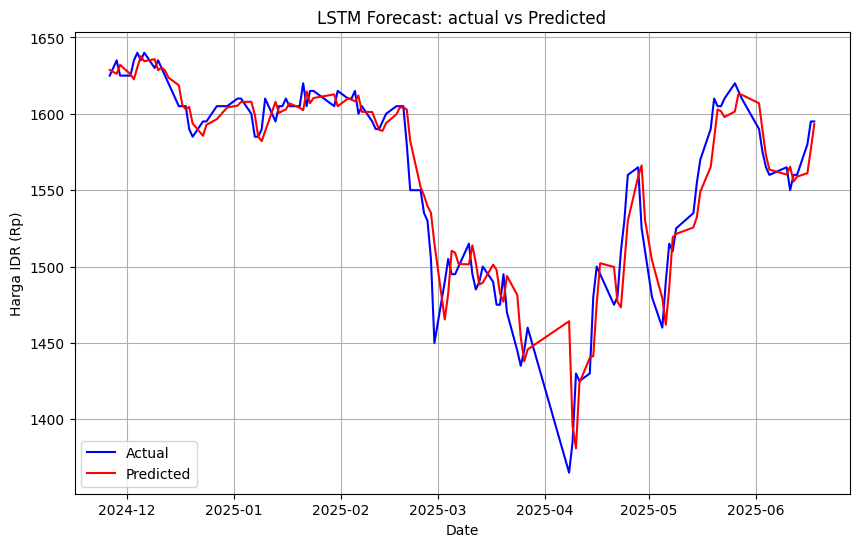

In [71]:
# Visualize predictions
test_dates = data.index[train_size + seq_length:]
comparison_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test_denorm.flatten(),
    'Predicted': predictions_denorm.flatten()
})

plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual'], color='blue', label='Actual')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], color='red', label='Predicted')
plt.title('LSTM Forecast: actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Harga IDR (Rp)')
plt.legend()
plt.grid(True)
plt.show()

# Plot forecast LSTM

In [76]:
# Fungsi forecasting tanpa volatilitas dan penyesuaian adaptif
def forecast_future_non_adaptive(model, last_sequence, n_periods, scaler):
    forecasts_scaled = []
    # Keras/TensorFlow bekerja dengan NumPy arrays atau TensorFlow Tensors.
    # Unsqueeze(0) untuk batch dimension, reshape ke (batch, timesteps, features)
    current_seq = np.array(last_sequence).reshape(1, last_sequence.shape[0], 1)

    for _ in range(n_periods):
        # Prediksi menggunakan model Keras
        pred = model.predict(current_seq, verbose=0)
        base_pred = pred[0, 0] # Keras .predict() mengembalikan array NumPy

        # Tanpa penyesuaian volatilitas dan tren
        adjusted_pred = base_pred
        adjusted_pred = np.clip(adjusted_pred, 0.0, 1.0) # Tetap pastikan dalam rentang 0-1

        forecasts_scaled.append(adjusted_pred)

        # Update sequence: buang elemen pertama, tambahkan yang baru di akhir
        current_seq = np.roll(current_seq, -1, axis=1) # Geser ke kiri
        current_seq[0, -1, 0] = adjusted_pred # Ganti elemen terakhir

    forecasts_scaled = np.array(forecasts_scaled).reshape(-1, 1)
    forecast_denorm = scaler.inverse_transform(forecasts_scaled).flatten()
    return forecast_denorm

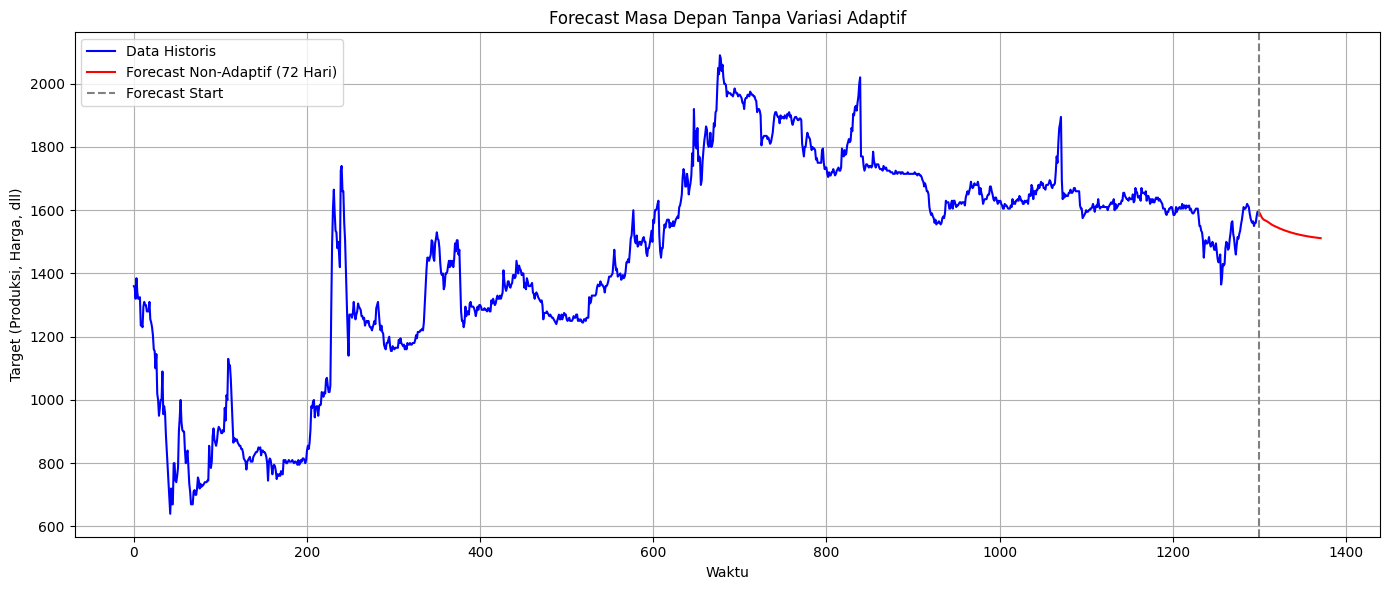


Future Forecasts (next 100 days, Non-Adaptive):
          Date  Forecast
0   2025-06-19    1593.0
1   2025-06-20    1589.0
2   2025-06-21    1583.0
3   2025-06-22    1577.0
4   2025-06-23    1573.0
..         ...       ...
67  2025-08-25    1513.0
68  2025-08-26    1513.0
69  2025-08-27    1512.0
70  2025-08-28    1512.0
71  2025-08-29    1512.0

[72 rows x 2 columns]


In [77]:
# Mengganti panggilan fungsi ke versi non-adaptif
window_size = min(20, len(scaler.inverse_transform(normalized_data).flatten()))
n_steps = 72
last_sequence = normalized_data[-window_size:]
forecast_var_non_adaptive = forecast_future_non_adaptive( # Menggunakan fungsi baru
    model=model_lstm,
    last_sequence=last_sequence,
    n_periods=n_steps,
    scaler=scaler,
)

# Plot gabungan
historical_plot = scaler.inverse_transform(normalized_data).flatten()
future_x = np.arange(len(historical_plot), len(historical_plot) + n_steps)

future_dates = pd.date_range(start=data.index[-1] + timedelta(days=1), periods=n_steps, freq='D')
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': forecast_var_non_adaptive, # Menggunakan hasil dari fungsi baru
    'Type': 'Forecast'
})

plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(historical_plot)), historical_plot, label='Data Historis', color='blue')
plt.plot(future_x, forecast_var_non_adaptive, label=f'Forecast Non-Adaptif ({n_steps} Hari)', color='red') # Label disesuaikan
plt.axvline(x=len(historical_plot), color='gray', linestyle='--', label='Forecast Start')
plt.title('Forecast Masa Depan Tanpa Variasi Adaptif')
plt.xlabel('Waktu')
plt.ylabel('Target (Produksi, Harga, dll)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display forecast results
forecast_non_volatil = pd.DataFrame({
    'Date': forecast_df['Date'].dt.strftime('%Y-%m-%d'),
    'Forecast': np.round(forecast_var_non_adaptive, 0) # Menggunakan hasil dari fungsi baru
})
print("\nFuture Forecasts (next 100 days, Non-Adaptive):")
print(forecast_non_volatil)

# Plot forecast LSTM (dengan Volatilitas)

In [78]:
def forecast_future_adaptive(model, last_sequence, n_periods, scaler, historical_data):
    historical_diff = np.diff(historical_data.flatten())
    mean_diff = np.mean(historical_diff)
    sd_diff = np.std(historical_diff)

    window_size = min(20, len(historical_diff))
    recent_volatility = np.std(historical_diff[-window_size:])
    max_change = np.max(np.abs(historical_diff))

    min_val = scaler.data_min_[0]
    max_val = scaler.data_max_[0]

    forecasts_scaled = []
    current_seq = np.array(last_sequence).reshape(1, last_sequence.shape[0], 1)

    for _ in range(n_periods):
        pred = model.predict(current_seq, verbose=0)
        base_pred = pred[0,0]

        volatility_factor = recent_volatility / (max_val - min_val) * 3
        nonlinearity_adjust = np.random.normal(0, volatility_factor) * (max_change / (max_val - min_val)) * 2
        trend_adjust = (mean_diff / (max_val - min_val)) * (1 + np.random.normal(0, 0.3))

        adjusted_pred = base_pred + nonlinearity_adjust + trend_adjust
        adjusted_pred = np.clip(adjusted_pred, 0.0, 1.0)

        forecasts_scaled.append(adjusted_pred)

        current_seq = np.roll(current_seq, -1, axis=1) # Geser ke kiri
        current_seq[0, -1, 0] = adjusted_pred

    forecasts_scaled = np.array(forecasts_scaled).reshape(-1, 1)
    forecast_denorm = scaler.inverse_transform(forecasts_scaled).flatten()
    return forecast_denorm

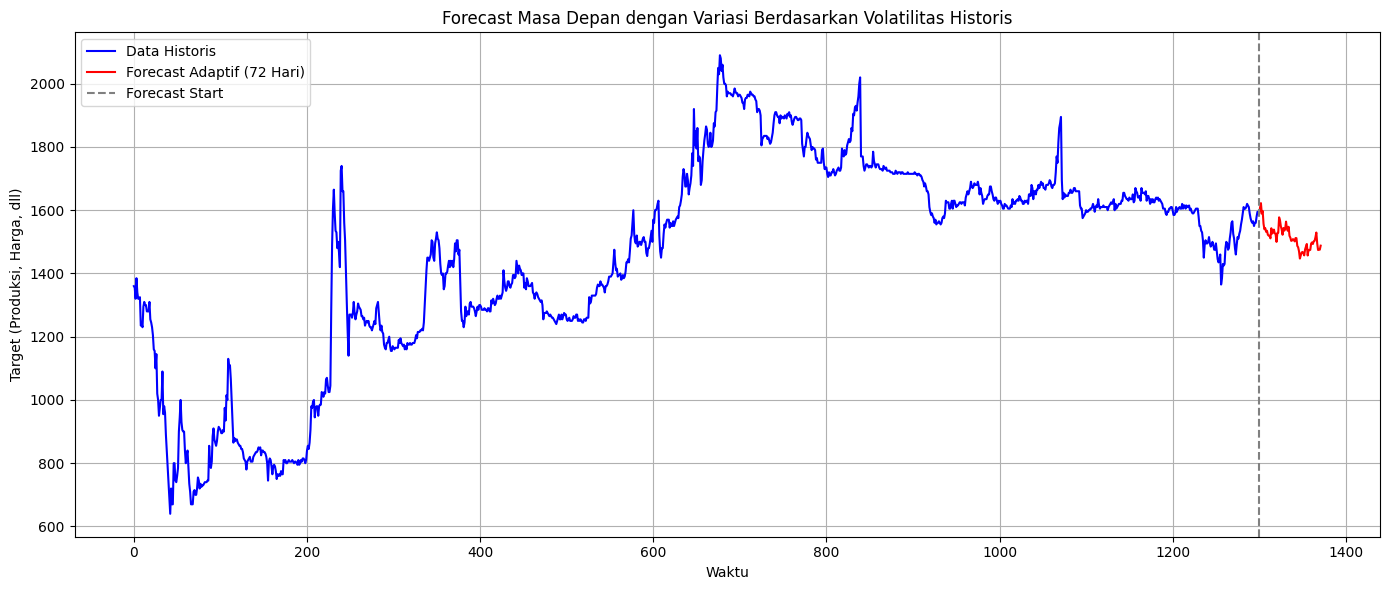


Future Forecasts (next 100 days):
       Date  Forecast
0   2025-06    1589.0
1   2025-06    1608.0
2   2025-06    1622.0
3   2025-06    1589.0
4   2025-06    1598.0
..      ...       ...
67  2025-08    1495.0
68  2025-08    1474.0
69  2025-08    1475.0
70  2025-08    1475.0
71  2025-08    1488.0

[72 rows x 2 columns]


In [79]:
# Forecast dengan variasi adaptif
window_size = min(20, len(scaler.inverse_transform(normalized_data)))
n_steps = 72
last_sequence = normalized_data[-window_size:]
forecast_var = forecast_future_adaptive(
    model=model_lstm,
    last_sequence=last_sequence,
    n_periods=n_steps,
    scaler=scaler,
    historical_data=scaler.inverse_transform(normalized_data),  # Data asli (denormalisasi)
)

# Plot gabungan
historical_plot = scaler.inverse_transform(normalized_data)
future_x = np.arange(len(historical_plot), len(historical_plot) + n_steps)

future_dates = pd.date_range(start=data.index[-1] + timedelta(days=1), periods=n_steps, freq='D')
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': forecast_var,
    'Type': 'Forecast'
})

plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(historical_plot)), historical_plot, label='Data Historis', color='blue')
plt.plot(future_x, forecast_var, label=f'Forecast Adaptif ({n_steps} Hari)', color='red')
plt.axvline(x=len(historical_plot), color='gray', linestyle='--', label='Forecast Start')
plt.title('Forecast Masa Depan dengan Variasi Berdasarkan Volatilitas Historis')
plt.xlabel('Waktu')
plt.ylabel('Target (Produksi, Harga, dll)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display forecast results
forecast_volatil = pd.DataFrame({
    'Date': forecast_df['Date'].dt.strftime('%Y-%m'),
    'Forecast': np.round(forecast_var, 0)
})
print("\nFuture Forecasts (next 100 days):")
print(forecast_volatil)

## Save Model LSTM

In [ ]:
from tensorflow.keras.models import Sequential, load_model # Pastikan load_model juga diimpor

# ... (kode Anda untuk membangun dan melatih model Keras Anda) ...
# Contoh:
# model = Sequential([
#     LSTM(50, activation='relu', input_shape=(timesteps, features)),
#     Dense(1)
# ])
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, y_train, epochs=..., batch_size=...)

# --- Cara Menyimpan Model ---
# Menyimpan dalam Format HDF5
# Ini akan membuat satu file .h5
#model_lstm.save('lstm_model_2.h5')
#print("Model berhasil disimpan dalam format HDF5 di 'my_lstm_model.h5'")

# --- Load Model ---
#model_lstm_load = load_model('lstm_model_1')
#print("\nModel berhasil dimuat ulang dari SavedModel:")
#model_lstm_load.summary()

Model berhasil disimpan dalam format HDF5 di 'my_lstm_model.h5'
